In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Logistic Regression

Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant’s scores on two exams and the admissions decision.
Your task is to build a classification model that estimates an applicant’s probability of admission based the scores from those two exams

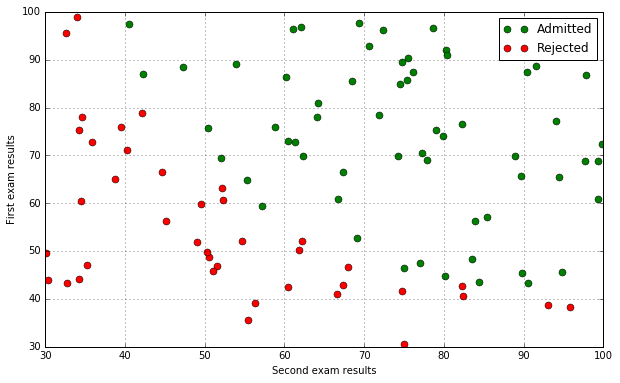

In [2]:
# Load initial data
datafile = 'ex2/ex2data1.txt'
data = np.loadtxt(datafile, delimiter=',', unpack=True)

# Fit data into features and results
X = np.transpose(np.array(data[:-1]))
Y = np.transpose(np.array(data[-1:]))

m = len(Y)
# Add column of 1s.
X = np.insert(X,0,1,axis=1)

#Plot initial data
admitted = np.array([X[i] for i in range(len(Y)) if Y[i] == 1])
rejected = np.array([X[i] for i in range(len(Y)) if Y[i] == 0])

def plot():
    plt.figure(figsize=(10,6))
    plt.plot(admitted[:,1],admitted[:,2],'go',markersize=7, label="Admitted")
    plt.plot(rejected[:,1],rejected[:,2],'ro', markersize=7, label="Rejected")
    plt.ylabel('First exam results')
    plt.xlabel('Second exam results')
    plt.legend(loc='upper right')
    plt.legend()
    plt.grid(True)
    
plot()

### Implementation

##### Sigmoid function

In [3]:
from scipy.special import expit
# sigmoid function is imported from scipy
# sigmoid(0) should be exactly 0.5
print expit(0)

0.5


In [4]:
# hypothesis function for logistic regression
def hypothesis(X, weights):
    return expit(np.dot(X, weights))

##### Cost function and gradient

In [20]:
def compute_cost(weights, X, Y):
    h = hypothesis(X, weights)
    cost = -(1./m) * (np.dot(Y.T,np.log(h)) + np.dot((1-Y).T,np.log(1-h)))
    return np.sum(cost)

initial_weights = np.zeros((X.shape[1],1))
compute_cost( initial_weights, X, Y)

0.69314718055994529

#### Finding optimal theta parameters
"You wrote a cost function and calculated its gradient, then took a gradient descent step accordingly. This time, instead of taking gradient descent steps, you will use an Octave/- MATLAB built-in function called fminunc"

Scipy has several alternatives that can find optimum weights and are similar to Octave's fminunc. They are listed here: http://docs.scipy.org/doc/scipy-0.10.0/reference/tutorial/optimize.html

We could use either `fmin` or `fmin_bfgs` (the internet says octave's fminunc is implemented using bfgs).

In [7]:
from scipy.optimize import fmin

def optimize_weights(weights, X, Y):
    result = fmin(compute_cost,x0=weights,args=(X,Y),maxiter=400,full_output=True)
    return result[0],result[1]

In [8]:
optimum_weights, minimum_cost = optimize_weights(initial_weights, X, Y)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287


In [9]:
"""
Call your costFunction function using the optimal parameters of θ. 
You should see that the cost is about 0.203.
"""
print compute_cost(optimum_weights, X, Y)

0.20349770159


#### Evaluating logistic regression

In [10]:
# Initially plot decision boundry
def plot():
    plot_x = np.array([np.min(X[:,1]), np.max(X[:,1])])
    plot_y = (-1./optimum_weights[2])*(optimum_weights[0] + optimum_weights[1]*plot_x)
    plot()
    plt.plot(plot_x,plot_y,'b-',label='Decision Boundary')
    plt.legend()

In [11]:
"""
After learning the parameters, you can use the model to predict 
whether a particular student will be admitted. For a student 
with an Exam 1 score of 45 and an Exam 2 score of 85, 
you should expect to see an admission probability of 0.776.
"""
hypothesis([1.,45.,85.],optimum_weights)

0.77629159041124107

In [12]:
def classify_positive(features, weights):
    return hypothesis(features, weights) >= 0.5

def classify_negative(features, weights):
    return hypothesis(features, weights) < 0.5

# How many of the students we know are admitted are classified as positive
correct_positives = np.sum(classify_positive(admitted, optimum_weights))

# How many of the students we know are rejected are classified as negative
correct_negatives = np.sum(classify_negative(rejected, optimum_weights))

total_correct = correct_positives + correct_negatives
total_results = len(admitted) + len(rejected)
correct = float(total_correct) / total_results

print str(correct * 100) + "% accuracy."

89.0% accuracy.


### Regularized Logistic Regression

In [13]:
# Load and plot data
data = 'ex2/ex2data2.txt'
reglogdata = np.loadtxt(data, delimiter=',',unpack=True,usecols=(0,1,2))

X = np.transpose(np.array(reglogdata[:-1]))
Y = np.transpose(np.array(reglogdata[-1:]))

m = len(Y)

# Insert column of 1s
X = np.insert(X,0,1,axis=1)

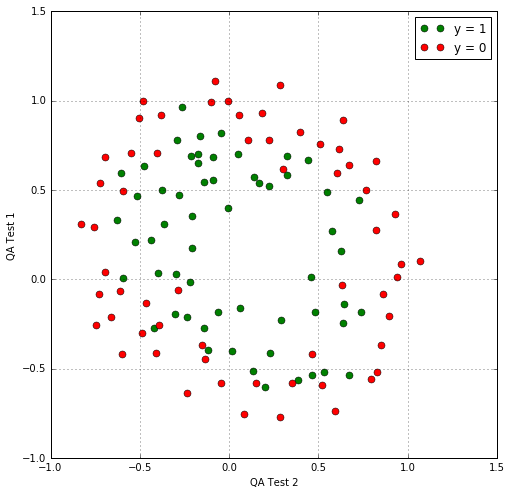

In [151]:
accepted = np.array([X[i] for i in range(len(X)) if Y[i] == 1])
rejected = np.array([X[i] for i in range(len(X)) if Y[i] == 0])

plt.figure(figsize=(8,8))
plt.plot(accepted[:,1],accepted[:,2],'go',markersize=7, label="y = 1")
plt.plot(rejected[:,1],rejected[:,2],'ro', markersize=7, label="y = 0")
plt.ylabel('QA Test 1')
plt.xlabel('QA Test 2')
plt.legend(loc='upper right')
plt.legend()
plt.grid(True)

Our data is not linearly separable. A straight line cannot separate positive from negative results.

#### Feature mapping
One way to fit the data better is to create more features from each data point.
We will map the features into all polynomial terms of x1 and x2 up to the sixth power. As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.
While the feature mapping allows us to build a more expressive classifier, it also more susceptible to overfitting.

In [14]:
def map_feature(x1, x2):
    """ 
    Function that takes in a column of n- x1's, a column of n- x2s, and builds
    a n- x 28-dim matrix of featuers as described in the homework assignment
    """
    degrees = 6
    out = np.ones((x1.shape[0], 1))

    for i in range(1, degrees+1):
        for j in range(0, i+1):
            term1 = x1 ** (i-j)
            term2 = x2 ** (j)
            term  = (term1 * term2).reshape( term1.shape[0], 1 ) 
            out   = np.hstack(( out, term ))
    return out

In [15]:
X_mapped = map_feature(X[:,1],X[:,2])

#### Cost function and gradient

In [16]:
def compute_regularized_cost(weights, X, Y, lmbda=0.):
    first = np.dot(Y.T, np.log(hypothesis(X, weights)))
    second = np.dot((1-Y).T,np.log(1-hypothesis(X,weights)))
    cost = -(1./m) * (first + second) + (lmbda/2 * np.sum(np.dot(weights[1:].T,weights[1:])))
    return np.sum(cost)

In [19]:
initial_weights = np.zeros((X_mapped.shape[1],1))

from scipy.optimize import minimize

def optimize_regularized_weights(weights, X, Y, lmbda=0.):
    result = minimize(compute_regularized_cost, initial_weights, args=(X, Y, lmbda),  method='BFGS', 
                      options={"maxiter":500, "disp":False} )
    return np.array([result.x]), result.fun

optimum_weights, minimum_cost = optimize_regularized_weights(initial_weights, X_mapped, Y)

print optimum_weights
print minimum_cost

[[   19.47096544    31.83733031    15.84916245  -190.1883393    -83.66549748
    -98.53821178  -234.03191615  -193.17582887  -126.72617071
    -39.46003923   654.08186604   498.71113278   808.07425089   333.640422
    178.76305192   399.12087532   516.90723192   615.15307244
    356.00560688   129.23617695    34.72997354  -766.6799324   -893.2261022
  -1496.71081886 -1032.60216281 -1009.09641584  -378.69078062
   -121.56777742]]
0.248645045331


In [20]:
# TO-DO plot for various values of lambda